# Классификация авто по типу кузова

**Описание проекта**

Предлагается набор данных, содержащий комплектации различных моделей автомобилей и их характеристики.

Необходимо произвести с данным датасетом следующие операции:

1. Анализ данных;
2. Фильтрация;
3. Преобразование переменных;
4. Классификация моделей по типу кузова (без подклассов, колонка `type_car`):

    - Седан;
    - Хетчбек;
    - Кроссовер;
    - Внедорожник.

![car_type_3.jpeg](attachment:car_type_3.jpeg)

**Задача**

- Обосновать выбранный подход/метод машинного обучения.
- Описать способ оценки качества модели машинного обучения.
- Необходимо детально описать все выполненные шаги.
- Данное задание необходимо выполнить только на языке **Python** в **Jupyter notebook**.

---
Ссылка на датасет: https://docs.google.com/spreadsheets/d/1nUqniflMlo-kWJk3OjmZYZ1OWVlBLno6/edit#gid=2095307267

## Импорт и начало работы

Объявим глобальные переменные.

In [ ]:
RS = 42

Импортируем библиотеки.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# Models
from sklearn.linear_model import LogisticRegression

# Sklearn tools
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss, ConfusionMatrixDisplay, confusion_matrix)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, PowerTransformer)

In [ ]:
def four_cls_balance(df, row):
    green = (0.55, 0.82, 0.78)
    red = (0.98, 0.50, 0.44)
    blue = (0.50, 0.64, 0.98)
    orange = (0.99, 0.65, 0.20)

    bal = df.groupby(row).agg({row: 'count'})
    features_num = range(len(bal))
    bars = plt.bar(features_num, bal[row], color=[green, red, blue, orange])

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x()+bar.get_width() / 2, h, str(h)+' (%.2f%%)' %
                 (h/len(df)*100), ha='center', va='bottom')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(ticks=features_num, labels=bal.index.to_list())
    plt.title('Баланс классов целевого признака')
    plt.xlabel('Значение класса')
    plt.ylabel('Частота класса')
    plt.show()

Импортируем данные.

In [ ]:
df = pd.read_csv('auto_complectations.csv')

Изучим данные в первом приближении.

In [ ]:
display(df.head(5))
df.info()

,brand,model,complect,type_car,seats,doors,Двигатель,Мощность,Крутящий момент двигателя,Коробка передач,Привод,Разгон до сотни,Максимальная скорость,Расход топлива (л/100 км)\nгород / трасса / смешанный,Дорожный просвет,Габариты (длина × ширина × высота),Колёсная база,Объём багажника,Объём багажника максимальный,Объём топливного бака,Масса автомобиля
0,Audi,A3 Sedan,1.4 TFSI 7AMT,Седан класса C,5,4,бензиновый (1395 см³),150 л. с.,250 Н·м,роботизированная (7 ступеней),передний,8.2 секунды,224 км/ч,5.9 / 4.1 / 4.8,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1320 кг
1,Audi,A3 Sedan,sport 1.4 TFSI 7AMT,Седан класса C,5,4,бензиновый (1395 см³),150 л. с.,250 Н·м,роботизированная (7 ступеней),передний,8.2 секунды,224 км/ч,5.9 / 4.1 / 4.8,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1320 кг
2,Audi,A3 Sedan,2.0 TFSI 7AMT,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),передний,6.8 секунды,250 км/ч,7.2 / 4.7 / 5.6,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1395 кг
3,Audi,A3 Sedan,2.0 TFSI 7AMT quattro,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),полный,6.2 секунды,242 км/ч,7.2 / 4.8 / 5.7,165 мм,4458 × 1796 × 1416,2637 мм,390 л,845 л,55 л,1465 кг
4,Audi,A3 Sedan,sport 2.0 TFSI 7AMT,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),передний,6.8 секунды,242 км/ч,7.2 / 4.7 / 5.6,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1395 кг


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1703 entries, 0 to 1702
Data columns (total 21 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   brand                                                 1703 non-null   object
 1   model                                                 1703 non-null   object
 2   complect                                              1703 non-null   object
 3   type_car                                              1703 non-null   object
 4   seats                                                 1703 non-null   int64 
 5   doors                                                 1703 non-null   int64 
 6   Двигатель                                             1703 non-null   object
 7   Мощность                                              1703 non-null   object
 8   Крутящий момент двигателя                             1703 non-null 

* В таблице 1700+ записей, пропущенных значений нет;
* Единицы измерения записаны в одну ячейку со значениями;
* Колонки частично названы на русском, частично на анлийском.

## Анализ данных

Посмотрим уникальные значения в целевом признаке `type_car`.

In [ ]:
print(df.type_car.unique())

['Седан класса C' 'Хэтчбек класса B' 'Седан класса D'
 'Универсал повышенной проходимости класса D' 'Универсал класса D'
 'Купе класса D' 'Хэтчбек класса D' 'Седан класса E' 'Универсал класса E'
 'Хэтчбек класса E' 'Седан класса F' 'Большой кроссовер'
 'Компактный кроссовер' 'Среднеразмерный кроссовер' 'Купе класса C'
 'Спорткупе' 'Кабриолет с мягкой крышей' 'Спорткупе класса D'
 'Спортседан класса E' 'Родстер' 'Большой внедорожник' 'Седан класса B'
 'Хэтчбек класса A' 'Кроссовер класса B' 'Вэн' 'Горячий хэтчбек класса C'
 'Внедорожник класса B' 'Среднеразмерный внедорожник' 'Хэтчбек класса C'
 'Универсал класса C' 'Спортседан класса D' 'Купе класса E' 'Пикап'
 'Горячий седан класса C' 'Минивэн' 'Компактвэн'
 'Универсал повышенной проходимости класса E']


Задача подразумевает классификацию на 4 класса: **седан**, **хетчбек**, **кроссовер** и **внедорожник**.

В признаке кроме них встречается еще **универсал**, **купе**, **кабриолет**, **родстер**, **вэн**, **пикап** и разные модификации. Понадобится провести анализ. Какие-то классы сольём в один, другие отфильтруем.

---
Проведём глубокий анализ данных с помощью `Pandas Profiling`.

**Комментарий:** для просмотра отчета, пожалуйста раскомментируйте ячейку и перезапустите ядро с доступом к датасету.

In [ ]:
#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#profile.to_notebook_iframe()

* Пропуски в данных есть в виде значений `нет данных`, `0`, или `0 / 0 / 0`;
* Численные значения нужно привести к численному типу;
* Признаки `model` и `complect` имеет слишком высокую вариабельность значений;

Переименуем колонки.

In [ ]:
df.columns = ['brand', 'model', 'complect', 'car_type', 'seats', 'doors', 'engine',
              'horsepower', 'torque', 'gearbox', 'drive_type', 'zero_to_100', 'max_speed',
              'fuel_consumption', 'clearance', 'dimensions', 'wheelbase', 'trunk_volume',
              'trunk_volume_max', 'tank_volume', 'weight']

Заведём словарь соответствий и создадим колонку с упрощенной информацией о типе кузова.

In [ ]:
car_type_dict = dict(
    {'Большой внедорожник': 'Внедорожник',
     'Среднеразмерный внедорожник': 'Внедорожник',
     'Внедорожник класса B': 'Внедорожник',
     'Большой кроссовер': 'Кроссовер',
     'Среднеразмерный кроссовер': 'Кроссовер',
     'Компактный кроссовер': 'Кроссовер',
     'Кроссовер класса B': 'Кроссовер',
     'Вэн': 'Вэн',
     'Минивэн': 'Вэн',
     'Компактвэн': 'Вэн',
     'Кабриолет с мягкой крышей': 'Кабриолет',
     'Купе класса C': 'Купе',
     'Купе класса D': 'Купе',
     'Купе класса E': 'Купе',
     'Спорткупе': 'Купе',
     'Спорткупе класса D': 'Купе',
     'Пикап': 'Пикап',
     'Родстер': 'Родстер',
     'Горячий седан класса C': 'Седан',
     'Спортседан класса D': 'Седан',
     'Спортседан класса E': 'Седан',
     'Седан класса B': 'Седан',
     'Седан класса C': 'Седан',
     'Седан класса D': 'Седан',
     'Седан класса E': 'Седан',
     'Седан класса F': 'Седан',
     'Универсал класса C': 'Универсал',
     'Универсал класса D': 'Универсал',
     'Универсал класса E': 'Универсал',
     'Универсал повышенной проходимости класса D': 'Универсал',
     'Универсал повышенной проходимости класса E': 'Универсал',
     'Хэтчбек класса A': 'Хэтчбек',
     'Хэтчбек класса B': 'Хэтчбек',
     'Хэтчбек класса C': 'Хэтчбек',
     'Хэтчбек класса D': 'Хэтчбек',
     'Хэтчбек класса E': 'Хэтчбек',
     'Горячий хэтчбек класса C': 'Хэтчбек'})

df['car_type_simplified'] = df.car_type.replace(car_type_dict)

В результате упрощения мы можем изучить баланс классов.

In [ ]:
display(df.car_type_simplified.value_counts())

Кроссовер      754
Седан          416
Внедорожник    174
Хэтчбек        128
Вэн             94
Универсал       54
Купе            43
Пикап           26
Родстер          9
Кабриолет        5
Name: car_type_simplified, dtype: int64

**Вывод**: ясно почему задача содержит именно эти классы, ведь они составляют топ-4.

---

Баланс топ-4 в виде гистограммы.

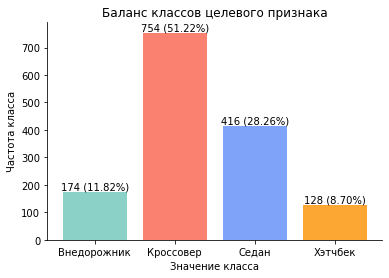

In [ ]:
key_type = ['Кроссовер', 'Седан', 'Внедорожник', 'Хэтчбек']
four_cls_balance(df[df.car_type_simplified.isin(key_type)], 'car_type_simplified')

Запомним индексы строк, с которыми будем работать.

In [ ]:
key_type_indices = df[df.car_type_simplified.isin(key_type)].index

## Фильтрация и преобразование переменных

Разделим информацию о двигателе на **тип** и **объем**.

In [ ]:
df['engine_type'] = df.engine.apply(lambda x: x.split()[0])
df['engine_volume'] = df.engine.apply(lambda x: int(x.split()[1][1:]))

Очистим признаки от единиц измерения внутри ячеек.

In [ ]:
features_to_clean = ['horsepower', 'torque', 'max_speed', 'clearance', 'wheelbase',
                     'trunk_volume', 'trunk_volume_max', 'tank_volume', 'weight']

for feature in features_to_clean:
    df[feature] = df[feature].apply(lambda x: int(x.split()[0]))

# разгон до 100 (сек)
df.zero_to_100 = df.zero_to_100.replace('нет данных', 'nan')
df.zero_to_100 = df.zero_to_100.apply(lambda x: float(x.split()[0]))

# заполним оставшиеся пропуски в `zero_to_100` индикативным значением `-1`
df.zero_to_100 = df.zero_to_100.fillna(-1)

В некоторых случаях цифры расхода топлива отсутствуют, поэтому оставим только смешанный режим.

In [ ]:
df.fuel_consumption = df.fuel_consumption.apply(lambda x: float(x.split('/')[2]))

Разделим информацию о коробке передач на **тип** и **число передач**.

In [ ]:
df['gearbox_type'] = df.gearbox.apply(lambda x: x.split()[0])
df['gearbox_gears'] = df.gearbox.apply(lambda x: int(x.split()[1][1:]))

Разделим информацию о размере на **длину** × **ширину** × **высоту**.

In [ ]:
df['length'] = df.dimensions.apply(lambda x: int(x.split('×')[0]))
df['width'] = df.dimensions.apply(lambda x: int(x.split('×')[1]))
df['height'] = df.dimensions.apply(lambda x: int(x.split('×')[2]))

Сделаем срез по индексам из `key_type_indices` и замерим вариабильность среди категориальных признаков.

In [ ]:
df_final = df.loc[key_type_indices]

for column in df_final.select_dtypes('object').columns:
    print(f'{column}: {df_final[column].nunique()}')

brand: 27
model: 202
complect: 1254
car_type: 21
engine: 106
gearbox: 15
drive_type: 3
dimensions: 230
car_type_simplified: 4
engine_type: 4
gearbox_type: 4


Уберём `model` и `brand`, потому что они будут давать утечку. Уберём `complect` из-за высокой вариабельности, а также уберем лишние после обработки дубликаты признаков.

In [ ]:
to_drop = ['brand', 'model', 'complect', 'car_type', 'engine', 'gearbox', 'dimensions']
df_final = df_final.drop(columns=to_drop)

Посмотрим на финальный результат предобработки.

In [ ]:
display(df_final.head(5))
df_final.info()

,seats,doors,horsepower,torque,drive_type,zero_to_100,max_speed,fuel_consumption,clearance,wheelbase,trunk_volume,trunk_volume_max,tank_volume,weight,car_type_simplified,engine_type,engine_volume,gearbox_type,gearbox_gears,length,width,height
0,5,4,150,250,передний,8.2,224,4.8,165,2637,425,880,50,1320,Седан,бензиновый,1395,роботизированная,7,4458,1796,1416
1,5,4,150,250,передний,8.2,224,4.8,165,2637,425,880,50,1320,Седан,бензиновый,1395,роботизированная,7,4458,1796,1416
2,5,4,190,320,передний,6.8,250,5.6,165,2637,425,880,50,1395,Седан,бензиновый,1984,роботизированная,7,4458,1796,1416
3,5,4,190,320,полный,6.2,242,5.7,165,2637,390,845,55,1465,Седан,бензиновый,1984,роботизированная,7,4458,1796,1416
4,5,4,190,320,передний,6.8,242,5.6,165,2637,425,880,50,1395,Седан,бензиновый,1984,роботизированная,7,4458,1796,1416


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1702
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   seats                1472 non-null   int64  
 1   doors                1472 non-null   int64  
 2   horsepower           1472 non-null   int64  
 3   torque               1472 non-null   int64  
 4   drive_type           1472 non-null   object 
 5   zero_to_100          1472 non-null   float64
 6   max_speed            1472 non-null   int64  
 7   fuel_consumption     1472 non-null   float64
 8   clearance            1472 non-null   int64  
 9   wheelbase            1472 non-null   int64  
 10  trunk_volume         1472 non-null   int64  
 11  trunk_volume_max     1472 non-null   int64  
 12  tank_volume          1472 non-null   int64  
 13  weight               1472 non-null   int64  
 14  car_type_simplified  1472 non-null   object 
 15  engine_type          1472 non-null   o

Оценим корреляцию признаков.

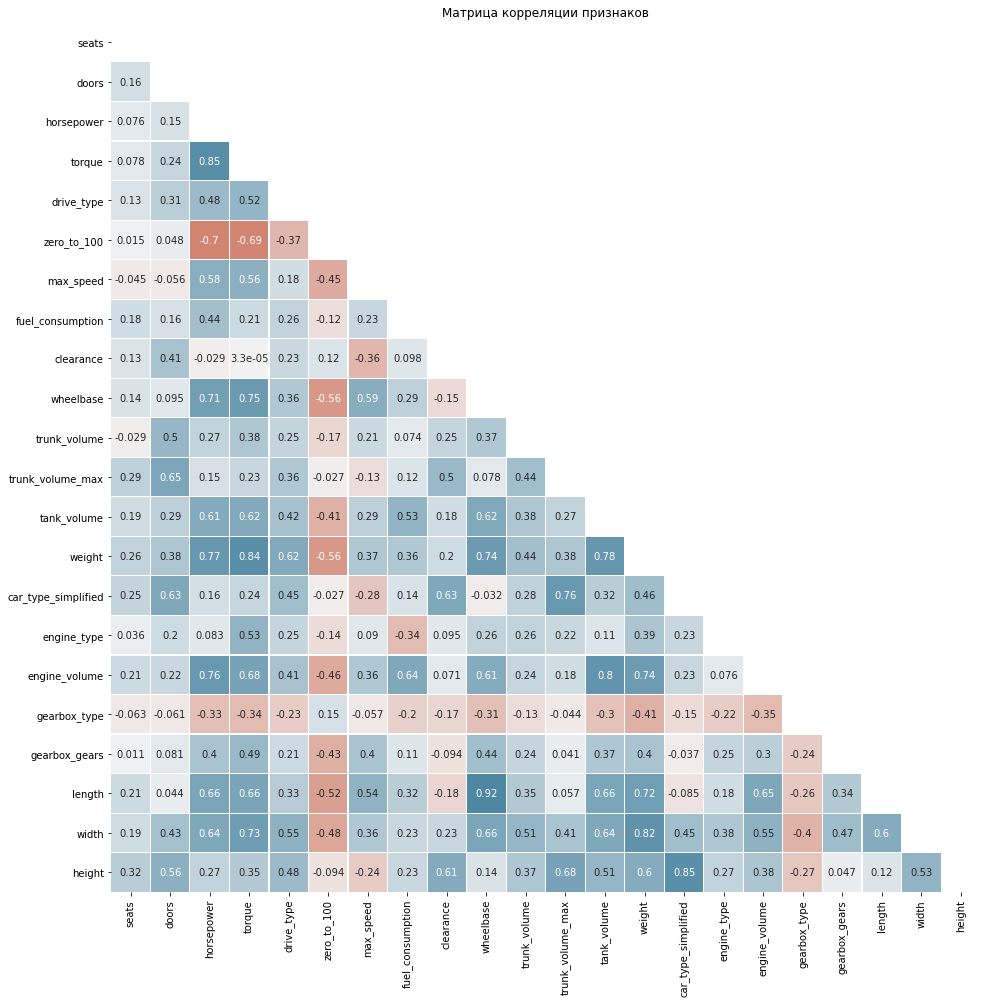

In [ ]:
# Сделаем копию данных
df_corr = df_final.copy()

car_type_mapper = dict({'Седан': 1, 'Хэтчбек': 2, 'Кроссовер': 3, 'Внедорожник': 4})
df_corr.car_type_simplified.replace(car_type_mapper, inplace=True)

# Найдём все категориальные признаки и кодируем их по порядку
cat_features = df_final.select_dtypes('object').columns.to_list()
for cat in cat_features:
    df_corr[cat] = df_corr[cat].astype('category').cat.codes

# Построим матрицу корреляции
corr = df_corr.corr()

# Сгенерируем маску для верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# Добавим кастомную цветовую схему
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Выведем тепловую карту с маской и симметричными ячейками
plt.figure(figsize=(16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar=False, annot=True)

plt.title('Матрица корреляции признаков')
plt.show()

Признаки `doors`, `clearance`, `trunk_volume_max`, `height` имееют корреляцию более 0.6 с целевым признаком `car_type_simplified`. Баланс классов в данных не позволяет делать выводы на основе корреляции. Однако, мы можем вручную проверить влиние тех или иных признаков в процессе обучения.

Обратим внимание на признаки с околонулевой корреляцией: `zero_to_100`, `wheelbase`, `gearbox_gears`, `length`.

---

**UPD:** базовое решение на основе логистической регрессии показало отличный результат без необходимости менять состав данных.

## Выбор модели

> В Sklearn классификаторы сгруппированы в 3 категории в зависимости от стратегии работы с мультиклассовыми данными.
>
> Первая и самая большая группа – это те, которые изначально поддерживают мультиклассовую классификацию. Еще две группы реализуют стратегии, называемые `One-vs-One (OVO)` и `One-vs-Rest (OVR, также называемый One-vs-All)`, трансформирующие задачу в серию бинарных подзадач.
>
> Остановимся подробнее на `OVO` и `OVR`.
>
> 1. `One-vs-One (OVO)` разделяет задачу с несколькими классами на одну задачу двоичной классификации для каждой пары классов. Другими словами, для каждой пары будет обучен бинарный классификатор. Например, для целевого признака с 4 классами будет обучено 6 классификаторов.  
>
> - Основным недостатком этой стратегии является её вычислительная нагрузка. Поскольку каждая пара классов требует отдельного бинарного классификатора, обучение на целевом признаке с высокой мощностью может занимать слишком много времени. Чтобы вычислить количество классификаторов, которые будут обучены для предсказания N-классов, используется следующая формула:
>
> $$\text{n_created} = \frac{N * (N - 1)}2$$
>
> 2. `One-vs-Rest (OVR)` создает индивидуальный классификатор для каждого класса цели. По сути, бинарный классификатор выбирает один класс и отмечает его как положительный, кодируя его как 1. Остальные классы считаются отрицательными и, таким образом, кодируются с помощью 0.
>
> - Несмотря на то, что эта стратегия значительно снижает вычислительные затраты, тот факт, что только один класс считается положительным, а остальные – отрицательными, делает каждую задачу бинарного предсказания несбалансированной по классам. Эта проблема еще более выражена для малочисленных классов в целевом признаке.
>
> В обоих подходах, в зависимости от выбранной модели, результаты всех бинарных классификаторов суммируются двумя способами:
>
> 1. По большинству голосов: каждый классификатор предсказывает один класс, и выбирается класс, получивший наибольшее количество голосов ото всех классификаторов;  
> 2. В зависимости от **argmax** оценок вероятностей принадлежности к классу: такие классификаторы, как **LogisticRegression**, вычисляют оценки вероятности для каждого класса (`.predict_proba()`). Затем выбирается **argmax** суммы оценок.
>  
> Источник: https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362

Перед нами задача полиномиальной классификации. Мы предсказываем тип кузова автомобиля на основе богатого признакового описания. Интуиция подсказывает, что существует линейная зависимость между размерами автомобиля, объёмом багажника, объёмом двигателя и типом кузова.

Для решения обратимся к методу логистической регрессии. Это быстрый и легко интерпретируемый метод, который наилучшим образом подходит для поиска линейных зависимостей. Его реализация в **Sklearn** нативно поддерживает задачу полиномиальной классификации.

В качестве ключевой метрики используем **ROC-AUC** по методу **OVR** со взвешенной по балансу классов оценкой. **ROC-AUC** покажет способность модели различать классы. **Accuracy** покажет сумму правильных предсказаний. Дополним метрикой **Log Loss** для демонстрации суммарной ошибки предсказания.

Построим матрицу ошибок, чтобы можно было визуально оценить качество разделения на классы.

In [ ]:
def score(clf):
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    logloss = log_loss(y_test, y_pred_proba)

    print(f'Accuracy {accuracy:.0%}')
    print('ROC-AUC score: %.4f' % roc_auc)
    print('Log loss score: %.4f' % logloss)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 5))

    # Create the matrix
    cm = confusion_matrix(y_test, y_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
    cmp.plot(ax=ax)
    plt.xlabel('Предсказание')
    plt.ylabel('Истина')

    plt.show()

Посмотрим на распределение каждого признака, чтобы решить, какой тип нормализации использовать.

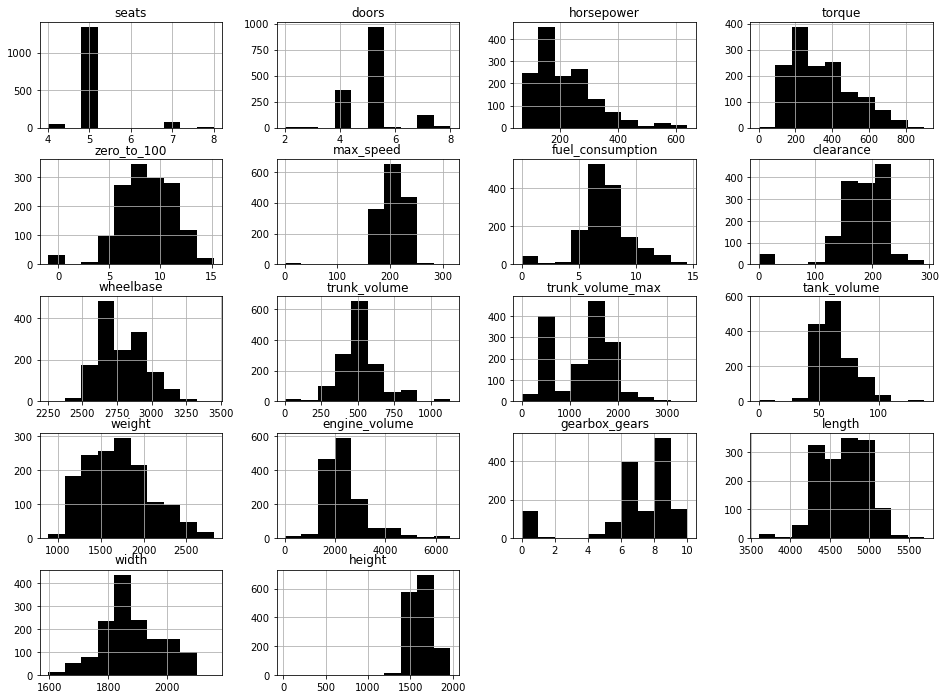

In [ ]:
df_final.hist(figsize=(16, 12), color='black');

`horsepower`, `torque`, `weight` имеют смещенное распределение. Применим логарифмирование, чтобы привести их распределения к нормальному. В остальных случаях используем обычную стандартизацию.

---

Подготовим выборки: тренировочную и валидационную.

In [ ]:
target = 'car_type_simplified'

X = df_final.drop(target, axis=1)
y = df_final[target]

# выделяем выборки под обучение и валидацию
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=RS)

**LogisticRegression**

Accuracy 98%
ROC-AUC score: 0.9971
Log loss score: 0.1262


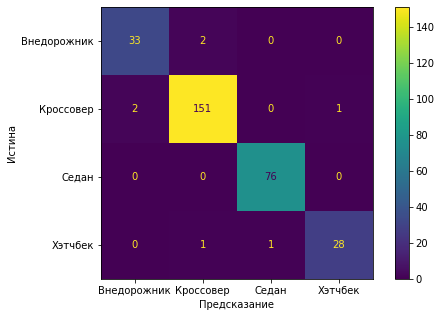

In [ ]:
# Признаки для категориального препроцессора
categorical_features = X.select_dtypes(include='object').columns.to_list()
categorical_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))

# Признаки для числового препроцессора
numeric_features = X.select_dtypes(exclude='object').columns.to_list()
to_log = ['horsepower', 'torque', 'weight']
to_scale = list(set(numeric_features) - set(to_log))
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Сборка препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_pipe, categorical_features),
        ('power_transform', numeric_pipe_1, to_log),
        ('standardization', numeric_pipe_2, to_scale),
    ]
)

# Финальный пайплайн комбинированный с LogisticRegression
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=200, multi_class='multinomial')),
    ]
)

# Fit & Predict
pipeline.fit(X_train, y_train)
score(pipeline)

* **Accuracy** показывает, что модель ошиблась в 2% случаев;
* **ROC-AUC** близкий к `1` говорит о том, что модель может отлично различать автомобили по типу кузова;
* **Log Loss** был бы полезен для сравнения моделей, однако задача успешно решена с первой попытки.

В матрице ошибок мы можем прочитать, что:
* в 4 случаях модель перепутала Внедорожник и Кроссовер;
* в 2 случаях Хэтчбек и Кроссовер;
* в 1 случае Хэтчбек и Cедан.

**Вывод**

На вход мы получили набор данных, содержащий комплектации различных моделей автомобилей и их характеристики. Мы провели анализ и обнаружили, что типов кузовов больше, чем мы хотели бы предсказывать. Поэтому мы объединили аналогичные автомобили в 4 группы, а оставшиеся малые группы отфильтровали.

Для применения алгоритмов машинного обучения необходимо привести признаковое описание к векторам с числами. Поэтому мы преобразовали категориальные переменные методом прямого кодирования, почистили численные переменные от единиц измерения, а сборные признаки разделили на несколько других.

На предобработанных данных мы обучили модель логистической регрессии. Этот алгоритм был выбран потому что он быстро работает, легко интерпретируется и не склонен к переобучению. Интуитивно можно почувствовать, что существует линейная зависимость между размерами автомобиля, объёмом багажника, двигателя и типом кузова. Логистическая регрессия отлично справилась с выявлением этой зависимости.

Мы использовали сразу несколько инструментов для оценки качества. С их помощью мы узнали, что модель отлично различает авто по типу кузова и ошибается только в 2% случаев, на схожих типах.

Таким образом, мы получили готовый инструмент для определения типа кузова автомобиля. Цель проекта можно считать выполненной.